# Metis Project 3 - Modeling
## Alison Glazer

#### Contents
[Import Libraries](#import_libraries)

[Load the Data](#load_the_data)

[Modeling](#modeling)
- [Set Up Features](#set-up)
- [Pairplot of features](#pairplot)
- [Target Distribution](#tar-dist)
- [Train Test Split](#split)
- [Logistic Regression](#logreg1)
- [Evaluating the Models](#eval)
- [Looking at Other Models](#others)
- [Decision Tree](#dt)
- [K-Nearest Neighbors](#knn)
- [Naive Bayes](#nb)
- [Support Vector Machine](#svm)
- [XGBoost](#xgb1)
- [Bagging Decision Trees](#bdt)
- [Random Forest](#rf)

[Model Comparison](#modelcomp)

[Model Tuning and Feature Selection](#tuning)
- [Logistic Regression Tuning](#lr-tuning)
- [XGBoost Tuning](#xgb-tuning)

[Visualizing Results](#viz)

<a class="anchor" id="import_libraries"></a>
## Import Libraries

In [1]:
# Data and Numbers
import pandas as pd
import numpy as np
import datetime as dt

# Modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score,\
precision_recall_curve,f1_score, fbeta_score,\
accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.externals.six import StringIO
from xgboost import XGBClassifier

# Saving
import joblib
import pickle

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Oswald']
font = {'size'   : 12}
plt.rc('font', **font)

%precision 5

/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


'%.5f'

<a class="anchor" id="load_the_data"></a>
## Load the Data

In [2]:
# Bring in pickled data file with cleaned data
with open('data/clean_df_modeling.pickle', 'rb') as read_file:
    df = pickle.load(read_file)
# with open('data/df.pickle','rb') as read_file:
#     df = pickle.load(read_file)

In [4]:
df.columns

Index(['permalink', 'name', 'category_list', 'funding_total_usd', 'status',
       'country_code', 'state_code', 'region', 'city', 'funding_rounds',
       'founded_at', 'first_funding_at', 'last_funding_at', 'status_bool',
       'company_name', 'avg_time_bw_rounds', 'avg_raise_usd',
       'time_bw_first_rounds', 'cat_list', 'country', 'state', 'seed_bool',
       'float_avg_time_bw_rounds', 'float_time_bw_first_rounds'],
      dtype='object')

<a class="anchor" id="modeling"></a>
## Modeling

<a class="anchor" id="set-up"></a>
### Set up features and target=status_bool

In [5]:
# Category Dummies
cat_dummies = pd.get_dummies(df['cat_list'], drop_first=True)
# Country Dummies
country_dummies = pd.get_dummies(df['country'], drop_first=True)
# State Dummies
state_dummies = pd.get_dummies(df['state'], drop_first=True)

In [6]:
df['state'].unique()

array(['0_other_state', 'CA', '2', 'NY', 'MA', 'FL', 'H9', 'WA', 'IL',
       'TX', 'unknown', '7', 'PA'], dtype=object)

In [7]:
# Create dummy variables for category, country, and state

X_col_nodummies = [
    'funding_rounds', 'float_avg_time_bw_rounds', 'avg_raise_usd',
    'float_time_bw_first_rounds'
]
X_nodummies = df[X_col_nodummies]

In [8]:
# Merge in dummies to feature matrix
X = X_nodummies.merge(cat_dummies, left_index=True, right_index=True).merge(
    country_dummies, left_index=True, right_index=True).merge(state_dummies,
                                                              left_index=True,
                                                              right_index=True)

# Add intercept column
X['intercept'] = 1

In [9]:
# Target
y = df.status_bool

In [10]:
# Export for visualizations in Tableau
df.to_csv('data/df.csv')

<a class="anchor" id="pairplot"></a>
### Look at data on pairplot, inspect for feature interactions

/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


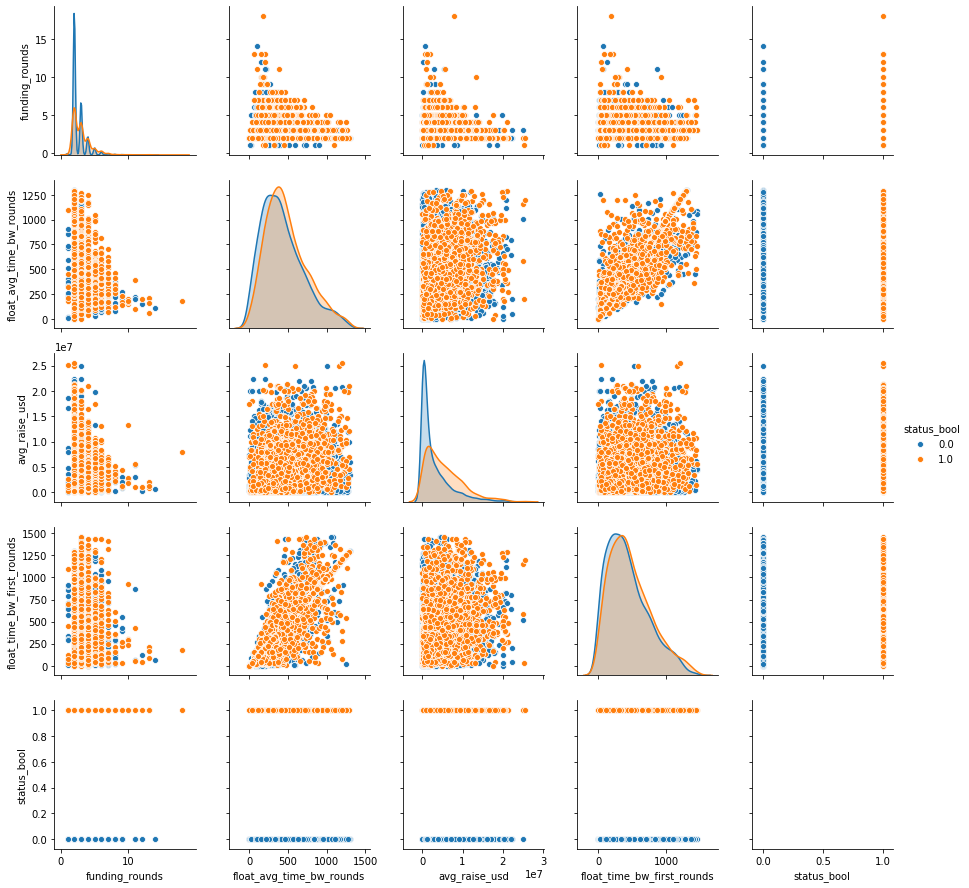

In [12]:
sns.pairplot(df[X_col_nodummies + ['status_bool']], hue='status_bool')

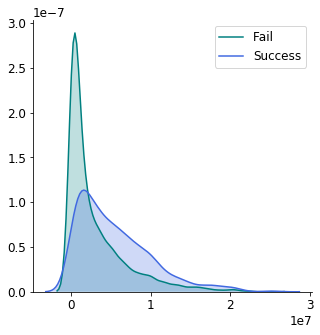

In [113]:
# Take a closer look at some of the features

# Average raise amount
plt.figure(figsize=(5, 5))
sns.kdeplot(df[df.status_bool == 0]['avg_raise_usd'],
            label='Fail',
            shade=True,
            color='teal')
sns.kdeplot(df[df.status_bool == 1]['avg_raise_usd'],
            label='Success',
            shade=True,
            color='royalblue')
sns.despine()
plt.savefig('img/avg_raise_kde.png')

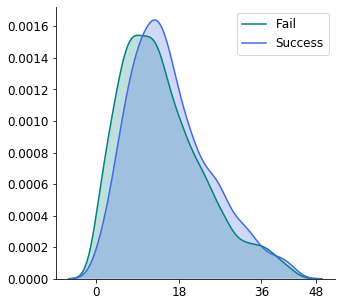

In [126]:
# average time between rounds
plt.figure(figsize=(5, 5))
sns.kdeplot(df[df.status_bool == 0]['float_avg_time_bw_rounds'],
            label='Fail',
            shade=True,
            color='teal')
sns.kdeplot(df[df.status_bool == 1]['float_avg_time_bw_rounds'],
            label='Success',
            shade=True,
            color='royalblue')
sns.despine()
plt.xticks((0, 540, 1080, 1440), ('0', '18', '36', '48'))
plt.savefig('img/avg_time_kde.png')

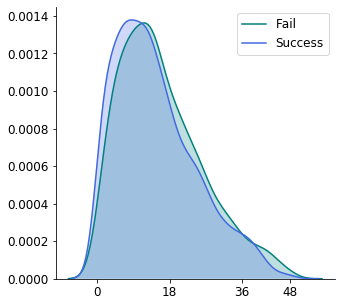

In [125]:
# average time between rounds
plt.figure(figsize=(5, 5))
sns.kdeplot(df[df.status_bool == 1]['float_time_bw_first_rounds'],
            label='Fail',
            shade=True,
            color='teal')
sns.kdeplot(df[df.status_bool == 0]['float_time_bw_first_rounds'],
            label='Success',
            shade=True,
            color='royalblue')
sns.despine()
plt.xticks((0, 540, 1080, 1440), ('0', '18', '36', '48'))
plt.savefig('img/first_time_kde.png')

<a class="anchor" id="tar-dist"></a>
### Inspect distribution of targets

In [26]:
# Count target values
target_count = y.value_counts()

# # print class balance
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print('Percentage of Majority Class: {:f}'.format(
    round(target_count[0] / sum(target_count), 4) * 100))

Class 0: 3667
Class 1: 1931
Proportion: 1.9 : 1
Percentage of Majority Class: 65.510000


The dataset is not very imbalanced, so we should not need to oversample the minority class, but later on we will try oversampling to see how it affects the results

In [27]:
target_count

0.0    3667
1.0    1931
Name: status_bool, dtype: int64

<a class="anchor" id="split"></a>
### Train test split + standardize the data

In [76]:
# Split the data with 80% to train and 20% to test
# Stratify to ensure train and test sets have 
# similar proportions of either target class
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=40,
                                                    stratify=y)

In [77]:
# Standardize the data

scaler = StandardScaler()

# Fit the scaler using the training data and scale it
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values),
                              columns=X.columns)

# Scale the test data
X_test_scaled = pd.DataFrame(scaler.transform(X_test.values),
                             columns=X.columns)

<a class="anchor" id="logreg1"></a>
Going to test out a bunch of classification algorithms to see which performs the best then try to optimize the top ones by tuning their hyperparameters as well as feature selection and any additional feature engineering
### Logistic Regression

In [31]:
# Instantiate model
logreg = LogisticRegression(C=10, solver='lbfgs')

# Fit model to the training data
logreg.fit(X_train_scaled, y_train)

# Pickle this for later
joblib.dump(logreg, 'logreg.pkl')

In [32]:
# Calculate ROC curve for logistic regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(
    y_test,
    logreg.predict_proba(X_test_scaled)[:, 1])

# Calculate area under the curve (AUC) for ROC
auc_lr = roc_auc_score(y_test, logreg.predict_proba(X_test_scaled)[:, 1])

<a class="anchor" id="eval"></a>
### Evaluating the Models

#### Calculating f_beta
The F-beta score weights recall more than precision by a factor of beta

Weigh recall more heavily than precision because in the case of venture capital investments, it is worse to miss out on a potential unicorn investment (10-100X return) (type II error - false negative) than to invest in a dud (1X loss) (type 1 error - false positive), however we won't place all weight on recall as it is still valuable for a VC firm to distinguish itself by reducing the amount of "duds" it invests in

If viewing from the prospective of a founder, they would prioritize precision since starting a company requires a lot of time and effort, they want to really improve the likelihood of starting a successful company

Find the probability threshold which optimizes the f_beta score

In [98]:
def fbeta(model, y_test=y_test, X_test=X_test_scaled):
    """
    Calculate the probability threshold that yields the highest f_beta value
    input: fitted model, y_test, X_test
    """
    prob_thresholds = np.arange(0, 1, 0.005)
    fbeta = []
    for prob in prob_thresholds:
        fbeta.append(
            fbeta_score(y_test,
                        model.predict_proba(X_test)[:, 1] > prob, 3))
    all_fbeta = list(zip(prob_thresholds, fbeta))
    best_fbeta = max(list(zip(prob_thresholds, fbeta)), key=lambda x: x[1])
    print(
        'Probability that yields the best fbeta score is {} with fbeta={:5f}'.
        format(best_fbeta[0], best_fbeta[1]))
    return all_fbeta, best_fbeta

In [48]:
# Calculate fbeta for logistic regression
all_fbeta_lr, best_fbeta_lr = fbeta(logreg, X_test=X_test_scaled)
p_thresh = best_fbeta_lr[0]

Probability that yields the best fbeta score is 0.115 with fbeta=0.846360


/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metric

#### Precision Recall Curve (with f_beta)

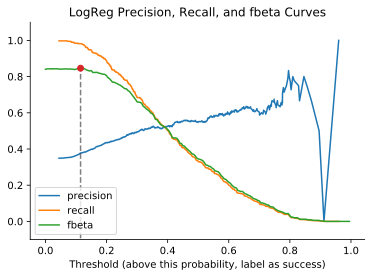

In [49]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(
    y_test,
    logreg.predict_proba(X_test_scaled)[:, 1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:], label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.plot(list(zip(*all_fbeta_lr))[0],
         list(zip(*all_fbeta_lr))[1],
         label='fbeta')
plt.plot([best_fbeta_lr[0], best_fbeta_lr[0]], [-1, best_fbeta_lr[1]],
         '--',
         color='black',
         alpha=0.5)
plt.plot(best_fbeta_lr[0], best_fbeta_lr[1], 'o')
plt.ylim([-0.1, 1.1])
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as success)')
plt.title('LogReg Precision, Recall, and fbeta Curves')
sns.despine()
plt.savefig('img/init_lr_precisionrecallcurve.png')
plt.savefig('img/init_lr_precisionrecallcurve.svg')

In [50]:
lr_coefs = list(zip(X.columns, logreg.coef_[0]))
lr_coefs_df = pd.DataFrame(lr_coefs)
lr_top_coefs = [x for x in lr_coefs if np.abs(x[1]) > .07]
lr_top_coefs = sorted(lr_top_coefs, key=(lambda x: x[1]), reverse=True)
lr_top_coefs_df = pd.DataFrame(lr_top_coefs)
lr_top_coefs_df.to_csv('data/lr_coefs.csv')

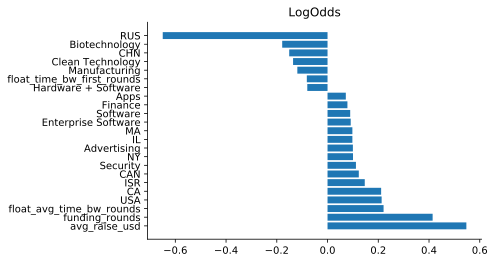

In [51]:
plt.barh([x[0] for x in lr_top_coefs], width=[x[1] for x in lr_top_coefs])
plt.title('LogOdds')
plt.grid(b=False)
sns.despine()

<a class="anchor" id="others"></a>
## Looking at other models
<a class="anchor" id="dt"></a>
### Decision Tree
Similar to logistic regression, decision tree is very easy to interpret, so this will be another way to look into the feature importances.

Decision tree does not require data to be scaled

In [52]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

# Calculate fbeta for decision tree
all_fbeta_dt, best_fbeta_dt = fbeta(dt,
                                    X_test=X_test)  # not scaled data for dt

# Calculate ROC Score and AUC for decision tree
fpr_dt, tpr_dt, thresholds_dt = roc_curve(
    y_test,
    dt.predict_proba(X_test)[:, 1])  # not scaled data for dt
auc_dt = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])

Probability that yields the best fbeta score is 0.07 with fbeta=0.838622


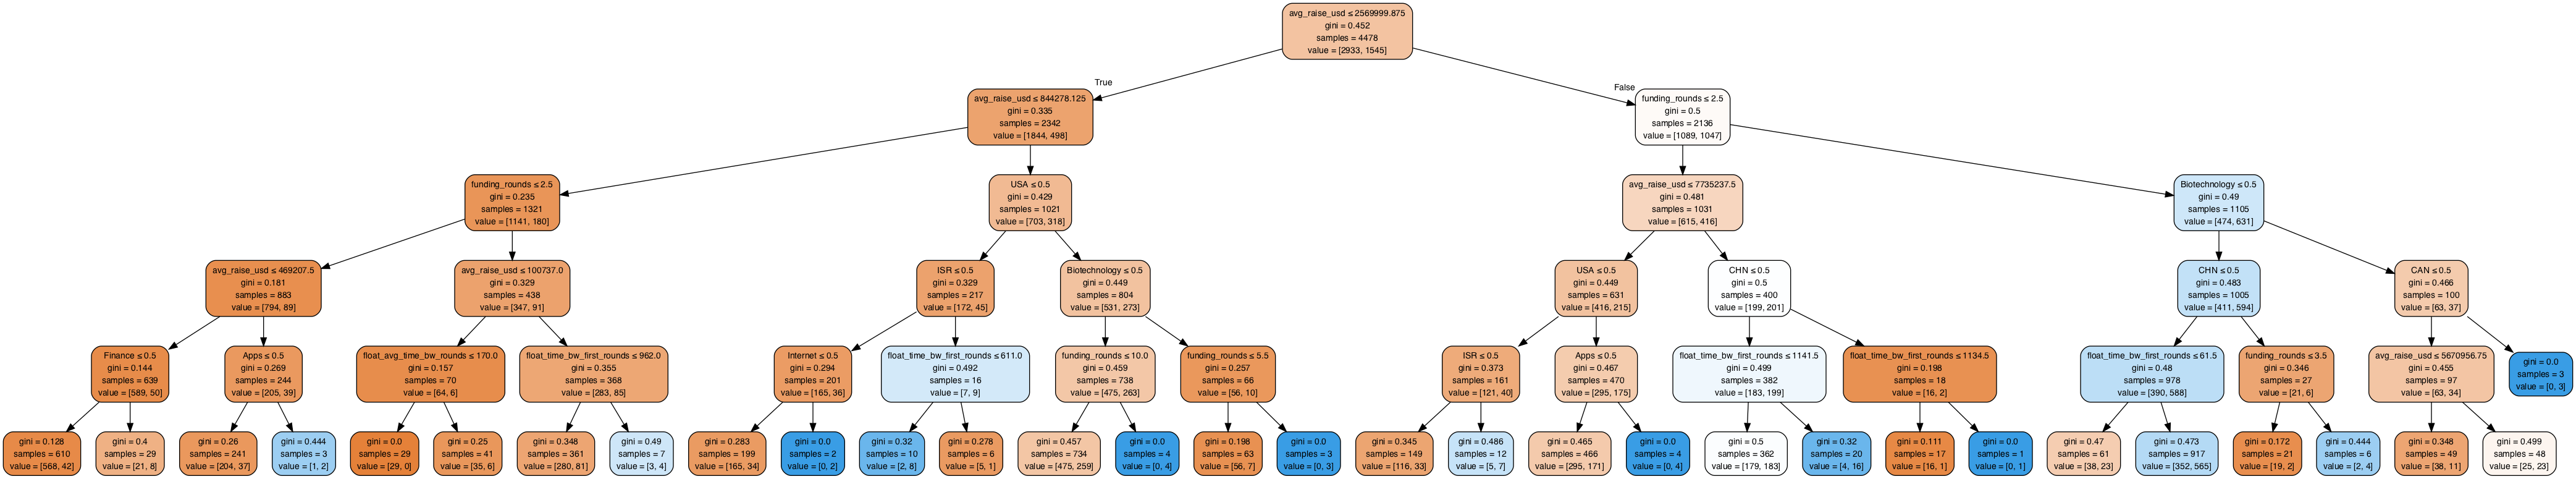

In [53]:
# This allows us to make a decision tree real fast directly in the notebook!
dot_data = StringIO()
export_graphviz(dt,
                out_file=dot_data,
                feature_names=X_train.columns.tolist(),
                filled=True,
                rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('img/decision_tree.png')
Image(graph.create_png())

Blue is a 1, red is a 0

In [54]:
# Feature importance

pd.DataFrame({
    'feature': X.columns,
    'importance': dt.feature_importances_
}).sort_values(by='importance', ascending=False)[0:15]

,feature,importance
2,avg_raise_usd,0.653635
0,funding_rounds,0.136180
3,float_time_bw_first_rounds,0.046285
7,Biotechnology,0.040015
30,CHN,0.038155
38,USA,0.027643
36,ISR,0.020807
6,Apps,0.013572
18,Internet,0.007797
29,CAN,0.007031


<a class="anchor" id="knn"></a>
### KNN
While KNN requires nearly zero time to train, it takes a long time to build predictions and is used less often than other classifiers in industry. That said, this project is an exercise in understanding the various classification algorithms so it is used below for completeness

In [68]:
# Instantiate Model
knn = KNeighborsClassifier(n_neighbors=5)

# Fit Model
knn.fit(X_train_scaled, y_train)

In [69]:
# Calculate fbeta for KNN
all_fbeta_knn, best_fbeta_knn = fbeta(knn,
                                      X_test=X_test_scaled)  # scaled for knn

# Calculate ROC Score and AUC for knn
fpr_knn, tpr_knn, thresholds_knn = roc_curve(
    y_test,
    knn.predict_proba(X_test_scaled)[:, 1])  # scaled for knn
auc_knn = roc_auc_score(
    y_test,
    knn.predict_proba(X_test_scaled)[:, 1])  # scaled for knn

Probability that yields the best fbeta score is 0.0 with fbeta=0.743726


<a class="anchor" id="nb"></a>
### Naive Bayes
#### Bernoulli
This works best on binary features

In [55]:
nbb = BernoulliNB()
nbb.fit(X_train_scaled, y_train)

In [56]:
# Calculate fbeta for Naive Bayes Bernoulli
all_fbeta_nbb, best_fbeta_nbb = fbeta(nbb,
                                      X_test=X_test_scaled)  # scaled for nbb

# Calculate ROC Score and AUC for Naive Bayes Bernoulli
fpr_nbb, tpr_nbb, thresholds_nbb = roc_curve(
    y_test,
    nbb.predict_proba(X_test_scaled)[:, 1])  # scaled for nbb
auc_nbb = roc_auc_score(
    y_test,
    nbb.predict_proba(X_test_scaled)[:, 1])  # scaled for nbb

Probability that yields the best fbeta score is 0.025 with fbeta=0.844085


/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metric

#### Gaussian
This works better on continuous features

In [57]:
nbg = GaussianNB()
nbg.fit(X_train_scaled, y_train)

In [58]:
# Calculate fbeta for Naive Bayes Gaussian
all_fbeta_nbg, best_fbeta_nbg = fbeta(nbg,
                                      X_test=X_test_scaled)  # scaled for nbg

# Calculate ROC Score and AUC for Naive Bayes Gaussian
fpr_nbg, tpr_nbg, thresholds_nbg = roc_curve(
    y_test,
    nbg.predict_proba(X_test_scaled)[:, 1])  # scaled for nbg
auc_nbg = roc_auc_score(
    y_test,
    nbg.predict_proba(X_test_scaled)[:, 1])  # scaled for nbg

Probability that yields the best fbeta score is 0.0 with fbeta=0.842611


NOTE: Multinomial Naive Bayes not tested here - this works better on count-based features - only one of my features is count-based (number of rounds) - this algorithm cannot handle negative data

<a class="anchor" id="svm"></a>

### Support Vector Machine

In [70]:
svm_model = svm.SVC(kernel="linear", probability=True)
svm_model.fit(X_train_scaled, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [71]:
# Calculate fbeta for SVM
all_fbeta_svm_model, best_fbeta_svm_model = fbeta(
    svm_model, X_test=X_test_scaled)  # scaled for SVM

# Calculate ROC Score and AUC for SVM
fpr_svm_model, tpr_svm_model, thresholds_svm_model = roc_curve(
    y_test,
    svm_model.predict_proba(X_test_scaled)[:, 1])  # scaled for SVM
auc_svm_model = roc_auc_score(
    y_test,
    svm_model.predict_proba(X_test_scaled)[:, 1])  # scaled for SVM

/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metric

Probability that yields the best fbeta score is 0.14 with fbeta=0.846819


<a class="anchor" id="xgb1"></a>
### XGBoost
Similar to other tree based algorithms but it uses boosting to calculate each subsequent tree which is necessarily sequential and thus takes longer to run since it cannot be parallelized

In [59]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [263]:
# Calculate fbeta for XGBoost
prob_thresholds = np.arange(0, 1, 0.005)
fbeta_xgb = []
for prob in prob_thresholds:
    fbeta_xgb.append(
        fbeta_score(y_test,
                    xgb.predict_proba(X_test)[:, 1] > prob, 3))
all_fbeta_xgb = list(zip(prob_thresholds, fbeta_xgb))
best_fbeta_xgb = max(list(zip(prob_thresholds, fbeta_xgb)), key=lambda x: x[1])
print('Probability that yields the best fbeta score is {} with fbeta={:5f}'.
      format(best_fbeta_xgb[0], best_fbeta_xgb[1]))

# Calculate ROC Score and AUC for Naive Bayes Gaussian
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(
    y_test,
    xgb.predict_proba(X_test)[:, 1])  # not scaled for xgboost
auc_xgb = roc_auc_score(
    y_test,
    xgb.predict_proba(X_test)[:, 1])  # not scaled for xgboost

Probability that yields the best fbeta score is 0.1 with fbeta=0.846085


In [213]:
xgb_feats = sorted(list(zip(X.columns, xgb.feature_importances_)),
                   key=(lambda x: x[1]),
                   reverse=True)

<a class="anchor" id="bdt"></a>
### Bagging Decision Trees
Ensemble of decision trees using bootstrapped samples from the training set

In [61]:
bag_dt = BaggingClassifier(DecisionTreeClassifier(),
                           n_estimators=500,
                           bootstrap=True,
                           oob_score=True,
                           random_state=1234,
                           n_jobs=-1)
# fit
bag_dt.fit(X_train, y_train)

In [67]:
# Calculate fbeta for Bagging Decision Trees
all_fbeta_bag_dt, best_fbeta_bag_dt = fbeta(
    bag_dt, X_test=X_test)  # not scaled for bag_dt

# Calculate ROC Score and AUC for bag dt
fpr_bag_dt, tpr_bag_dt, thresholds_bag_dt = roc_curve(
    y_test,
    bag_dt.predict_proba(X_test)[:, 1])  # not scaled for bag dt
auc_bag_dt = roc_auc_score(
    y_test,
    bag_dt.predict_proba(X_test)[:, 1])  # not scaled for bag dt

/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metric

Probability that yields the best fbeta score is 0.08 with fbeta=0.847038


<a class="anchor" id="rf"></a>
### Random Forest
Similar to bagging with decision trees, except at each split in a tree only a subset of the total number of features is considered, thus introducing further randomness and helping to decorellate the trees

In [62]:
# Instantiate Model
rf = RandomForestClassifier(n_estimators=500,
                            bootstrap=True,
                            oob_score=True,
                            random_state=1234,
                            n_jobs=-1)

# fit
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=1234, verbose=0,
                       warm_start=False)

In [63]:
# Calculate fbeta for Random Forest
all_fbeta_rf, best_fbeta_rf = fbeta(rf, X_test=X_test)  # not scaled for rf

# Calculate ROC Score and AUC for random forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(
    y_test,
    rf.predict_proba(X_test)[:, 1])  # not scaled for rf
auc_rf = roc_auc_score(y_test,
                       rf.predict_proba(X_test)[:, 1])  # not scaled for rf

/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metric

Probability that yields the best fbeta score is 0.055 with fbeta=0.843107


In [66]:
# Feature importance

rf_feats = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

# Look at top 10 features
rf_feats[0:10]

,feature,importance
2,avg_raise_usd,0.268818
1,float_avg_time_bw_rounds,0.191510
3,float_time_bw_first_rounds,0.186560
0,funding_rounds,0.065942
41,CA,0.017432
25,Software,0.016176
38,USA,0.015562
7,Biotechnology,0.012381
20,Mobile,0.011359
4,Advertising,0.010610


<a class="anchor" id="modelcomp"></a>
## Model Comparison

In [264]:
models = ['lr', 'dt', 'knn', 'nbb', 'nbg', 'svm', 'xgb', 'bag_dt', 'rf']
model_aucs = [
    auc_lr, auc_dt, auc_knn, auc_nbb, auc_nbg, auc_svm_model, auc_xgb,
    auc_bag_dt, auc_rf
]
model_fbetas = [
    best_fbeta_lr[1], best_fbeta_dt[1], best_fbeta_knn[1], best_fbeta_nbb[1],
    best_fbeta_nbg[1], best_fbeta_svm_model[1], best_fbeta_xgb[1],
    best_fbeta_bag_dt[1], best_fbeta_rf[1]
]
model_names = [
    'Logistic Regression', 'Decision Tree', 'KNN', 'Bernoulli Naive Bayes',
    'Gaussian Naive Bayes', 'Support Vector Machine', 'XGBoost',
    'Bagged Decision Tree', 'Random Forest'
]

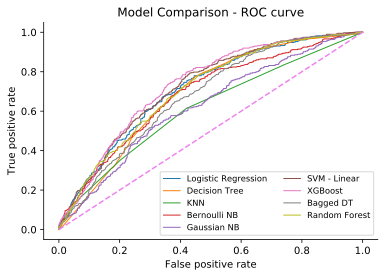

In [265]:
# Plot ROC Curves

plt.plot(fpr_lr, tpr_lr, lw=1, label='Logistic Regression')
plt.plot(fpr_dt, tpr_dt, lw=1, label='Decision Tree')
plt.plot(fpr_knn, tpr_knn, lw=1, label='KNN')
plt.plot(fpr_nbb, tpr_nbb, lw=1, label='Bernoulli NB')
plt.plot(fpr_nbg, tpr_nbg, lw=1, label='Gaussian NB')
plt.plot(fpr_svm_model, tpr_svm_model, lw=1, label='SVM - Linear')
plt.plot(fpr_xgb, tpr_xgb, lw=1, label='XGBoost')
plt.plot(fpr_bag_dt, tpr_bag_dt, lw=1, label='Bagged DT')
plt.plot(fpr_rf, tpr_rf, lw=1, label='Random Forest')

plt.plot([0, 1], [0, 1], c='violet', ls='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Model Comparison - ROC curve')
plt.legend(ncol=2, fontsize='small')
sns.despine()
plt.savefig('img/model_comp_roc.svg')
plt.savefig('img/model_comp_roc.png')

In [266]:
# Print AUC Scores
for model in list(zip(model_names, model_aucs)):
    print("ROC AUC score = {:3f} for {}".format(model[1], model[0]))

ROC AUC score = 0.712248 for Logistic Regression
ROC AUC score = 0.689236 for Decision Tree
ROC AUC score = 0.615624 for KNN
ROC AUC score = 0.684194 for Bernoulli Naive Bayes
ROC AUC score = 0.623865 for Gaussian Naive Bayes
ROC AUC score = 0.722403 for Support Vector Machine
ROC AUC score = 0.731721 for XGBoost
ROC AUC score = 0.677459 for Bagged Decision Tree
ROC AUC score = 0.705306 for Random Forest


In [267]:
# Print fbeta Scores
for model in list(zip(model_names, model_fbetas)):
    print("f_beta score = {:3f} for {}".format(model[1], model[0]))

f_beta score = 0.846360 for Logistic Regression
f_beta score = 0.838622 for Decision Tree
f_beta score = 0.743726 for KNN
f_beta score = 0.844085 for Bernoulli Naive Bayes
f_beta score = 0.842611 for Gaussian Naive Bayes
f_beta score = 0.846819 for Support Vector Machine
f_beta score = 0.846085 for XGBoost
f_beta score = 0.847038 for Bagged Decision Tree
f_beta score = 0.843107 for Random Forest


The best performance is seen in XGBoost. We'll hone in on this model as well as Logistic Regression, which also performed well and is highly interpretable to narrow down the list of features and optimize the predictive power of the models

<a class="anchor" id="tuning"></a>
## Model Tuning and Feature Selection

Look at the models that performed the best and tune their hyperparameters to improve performance further
For logistic regression, use regularization to narrow down the list of features
For tree based models, look at the feature importance to select the most important features

<a class="anchor" id="lr-tuning"></a>
### Logistic Regression Tuning
First - look at logistic regression model - try to optimize its hyperparameters and experiment with regularization to evaluate feature importance and feature collinearity

Try running a model with high regularization to see which coefficients go to zero

In [78]:
lr_reg = LogisticRegression(solver='saga',
                            C=0.1,
                            penalty='elasticnet',
                            l1_ratio=0.95)
lr_reg.fit(X_train_scaled, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.95, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [79]:
# Look at coefficients
lr_reg_coefs = pd.DataFrame(sorted(list(zip(X.columns, lr_reg.coef_[0])),
                                   key=(lambda x: x[1]),
                                   reverse=True),
                            columns=['Feature', 'Coefficient'])
lr_reg_coefs

,Feature,Coefficient
0,avg_raise_usd,0.532758
1,funding_rounds,0.399231
2,USA,0.206744
3,CA,0.175703
4,float_avg_time_bw_rounds,0.149334
5,ISR,0.131630
6,CAN,0.100592
7,Security,0.098822
8,Advertising,0.091259
9,Enterprise Software,0.081056


There are a lot of features with really low or zero coefficients - we can simplify the model by only keeping the important features without costing model performance

In [84]:
# Only select features with strong coefficients
X_sel_cols = list(lr_reg_coefs[abs(lr_reg_coefs['Coefficient']) > 0.05]
                  ['Feature'])  # Only keep features with higher coefficients
X_sel_cols.append('Mobile')
X_sel_cols.append('Advertising')
X_sel_cols.append('Finance')
X_sel_cols.append('intercept')

In [85]:
# Save column names
joblib.dump(X_sel_cols, 'X_sel_cols.pkl')

In [86]:
X_sel_cols_reorder = [
    'funding_rounds', 'float_time_bw_first_rounds', 'float_avg_time_bw_rounds',
    'avg_raise_usd', 'Advertising', 'Apps', 'Biotechnology',
    'Clean Technology', 'Education', 'Enterprise Software', 'Finance',
    'Hardware + Software', 'Manufacturing', 'Mobile', 'Software', 'CAN', 'CHN',
    'ISR', 'RUS', 'USA', 'CA', 'IL', 'MA', 'NY', 'intercept'
]

In [87]:
X_sel = X[X_sel_cols_reorder]

In [89]:
# Split the data with 80% to train and 20% to test
# Stratify to ensure train and test sets have 
# similar proportions of either target class
X_sel_train, X_sel_test, y_sel_train, y_sel_test = train_test_split(
    X_sel, y, test_size=0.2, random_state=40, stratify=y)

In [90]:
# Standardize the data with new scaler for selected columns

scaler_sel = StandardScaler()
scaler_sel.fit(X_sel_train.values)
# Save scaler for later
# joblib.dump(scaler_sel,'scaler_sel.pkl');
with open("scaler_sel.pkl", "wb") as f:
    pickle.dump(scaler_sel, f)

In [91]:
# Fit the scaler using the training data and scale it
X_sel_train_scaled = pd.DataFrame(scaler_sel.transform(X_sel_train.values),
                                  columns=X_sel_cols_reorder)

# Scale the test data
X_sel_test_scaled = pd.DataFrame(scaler_sel.transform(X_sel_test.values),
                                 columns=X_sel_cols_reorder)

In [92]:
X_sel.columns

Index(['funding_rounds', 'float_time_bw_first_rounds',
       'float_avg_time_bw_rounds', 'avg_raise_usd', 'Advertising', 'Apps',
       'Biotechnology', 'Clean Technology', 'Education', 'Enterprise Software',
       'Finance', 'Hardware + Software', 'Manufacturing', 'Mobile', 'Software',
       'CAN', 'CHN', 'ISR', 'RUS', 'USA', 'CA', 'IL', 'MA', 'NY', 'intercept'],
      dtype='object')

In [93]:
scaler_sel.transform(np.array(list(X_sel_test.iloc[1].values)).reshape(1, -1))

array([[-0.63315, -0.87916, -0.98768, -0.79069, -0.2411 , -0.10188,
        -0.27881, -0.1609 , -0.1488 , -0.23162, -0.18031,  6.13217,
        -0.10299, -0.27414, -0.45355, -0.17085, -0.13401, -0.12231,
        -0.09002, -1.76302, -0.66672, -0.13573, -0.26071, -0.29478,
         0.     ]])

In [94]:
# Try different values for C
c_vals = np.arange(0.1, 1.5, 0.1)

paramgrid = {'C': c_vals, 'penalty': ['l1', 'l2']}

# Define fold parameters
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [95]:
# Instantiate model
lr_sel = GridSearchCV(LogisticRegression(solver='saga'),
                      paramgrid,
                      cv=kf,
                      scoring='recall')

# Fit model to the training data
lr_sel.fit(X_sel_train_scaled, y_sel_train)

/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reac

In [96]:
# Get tuned model params
lr_tuned = lr_sel.best_estimator_
lr_tuned

LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [99]:
# Calculate area under the curve (AUC) for ROC
auc_lr_sel = roc_auc_score(y_sel_test,
                           lr_tuned.predict_proba(X_sel_test_scaled)[:, 1])
# Calculate fbeta
fbeta(lr_tuned, X_test=X_sel_test_scaled)

print('AUC = {}'.format(auc_lr_sel))

Probability that yields the best fbeta score is 0.09 with fbeta=0.844854
AUC = 0.7137164518360606


/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metric

Performance of the Logistic Regression improved slightly in AUC score

### Save Logistic Regression Model for use in flask app

In [100]:
# Create an attribute for the feature names
lr_tuned.feature_names = X_sel.columns
lr_tuned.target_names = ['Fail', 'Success']

In [101]:
X_sel.columns

Index(['funding_rounds', 'float_time_bw_first_rounds',
       'float_avg_time_bw_rounds', 'avg_raise_usd', 'Advertising', 'Apps',
       'Biotechnology', 'Clean Technology', 'Education', 'Enterprise Software',
       'Finance', 'Hardware + Software', 'Manufacturing', 'Mobile', 'Software',
       'CAN', 'CHN', 'ISR', 'RUS', 'USA', 'CA', 'IL', 'MA', 'NY', 'intercept'],
      dtype='object')

In [102]:
lr_tuned.feature_display_names = [
    'Number of Funding Rounds', 'Time Between First Rounds (months)',
    'Average Time Between Rounds (months)', 'Average Raise Amount ($)',
    'Advertising', 'Apps', 'Biotechnology', 'Clean Technology', 'Education',
    'Enterprise Software', 'Finance', 'Hardware + Software', 'Manufacturing',
    'Mobile', 'Software', 'Canada', 'China', 'Israel', 'Russia',
    'United States', 'California', 'Illinois', 'Massachusetts', 'New York',
    'int'
]

In [103]:
# Pickle this for later
with open("lr_tuned.pkl", "wb") as f:
    pickle.dump(lr_tuned, f)

#### Interpreting Coefficients and Intercept

In [104]:
# Intercept
lr_tuned.intercept_[0]

-0.7676364014515489

In [105]:
# convert intercept log-odds to probability
logodds = lr_tuned.intercept_
odds = np.exp(logodds)
prob = odds / (1 + odds)
prob[0]
print(
    'All else considered, companies that make it past their\
    first funding round, probability of success is {:.2f}%'
    .format(100 * prob[0]))

All else considered, companies that make it past their first funding round, probability of success is 31.70%


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


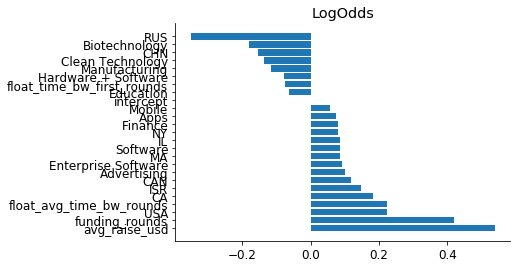

In [106]:
lr_tuned_coefs = pd.DataFrame(sorted(list(zip(X_sel.columns,
                                              lr_tuned.coef_[0])),
                                     key=(lambda x: x[1]),
                                     reverse=True),
                              columns=['Feature', 'Coefficient'])
lr_tuned_coefs['Odds'] = np.exp(lr_tuned_coefs.Coefficient)

# Plot coefficients
plt.barh(lr_tuned_coefs['Feature'], width=lr_tuned_coefs['Coefficient'])
plt.title('LogOdds')
plt.grid(b=False)
sns.despine()

# Save coefficients for plotting in Tableau
with open("lr_tuned_coefs.pkl", "wb") as f:
    pickle.dump(lr_tuned_coefs, f)

In [111]:
df['float_time_bw_first_rounds'].std()

306.2895971840483

In [107]:
lr_tuned_coefs

,Feature,Coefficient,Odds
0,avg_raise_usd,0.539126,1.714508
1,funding_rounds,0.418949,1.520363
2,USA,0.222762,1.249523
3,float_avg_time_bw_rounds,0.222558,1.249268
4,CA,0.182392,1.200085
5,ISR,0.146461,1.157729
6,CAN,0.118981,1.126348
7,Advertising,0.101296,1.106604
8,Enterprise Software,0.092859,1.097307
9,MA,0.086448,1.090295


<a class="anchor" id="xgb-tuning"></a>
### XGBoost Tuning
Want to optimize n_estimators and max_features and narrow down feature selection

First limit number of features by keeping features with non-zero feature importance values from the baseline XGB mdoel

In [225]:
X_sel_cols_xgb = [feat[0] for feat in xgb_feats if feat[1] > 0]

# Save column names
joblib.dump(X_sel_cols_xgb, 'X_sel_cols_xgb.pkl')

# Create new feature matrix
X_sel_xgb = X[X_sel_cols_xgb]

In [226]:
# Split the data with 80% to train and 20% to test
# Stratify to ensure train and test sets have 
# similar proportions of either target class
X_sel_xgb_train, X_sel_xgb_test, y_sel_xgb_train, y_sel_xgb_test = train_test_split(
    X_sel_xgb, y, test_size=0.2, random_state=40, stratify=y)


Set up hyperparameters to find the model with the best performance

In [254]:
paramgrid = {
    'n_estimators': [1000],
    'max_depth': [9, 6, 9],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Define fold parameters
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [255]:
# Instantiate model
xgb_sel = GridSearchCV(XGBClassifier(n_jobs=-1),
                       paramgrid,
                       cv=kf,
                       scoring='recall')

# Fit model to the training data
xgb_sel.fit(X_sel_xgb_train, y_sel_xgb_train)

In [256]:
xgb_tuned = xgb_sel.best_estimator_

In [268]:
# Calculate area under the curve (AUC) for ROC
auc_xgb_tuned = roc_auc_score(y_sel_xgb_test,
                              xgb_tuned.predict_proba(X_sel_xgb_test)[:, 1])
# Calculate fbeta
fbeta(xgb_tuned, X_test=X_sel_xgb_test)

print('AUC = {}'.format(auc_xgb_tuned))

Probability that yields the best fbeta score is 0.0 with fbeta=0.840226
AUC = 0.6527685617879178


<a class="anchor" id="viz"></a>
## Visualizing Results

To contextualize the results, look at the confusion matrix and assign relative dollar amounts to false positives and negatives and true positives and negatives

Since model performances were comparable, we'll move ahead with the logistic regression model as it is the easiest to interpret

In [127]:
lr_tuned.predict(X_sel_test_scaled)

array([0., 0., 0., ..., 0., 0., 0.])

In [128]:
annots = pd.DataFrame([['TN', 'FP'], ['FN', 'TP']])
type(annots)
annots

,0,1
0,TN,FP
1,FN,TP


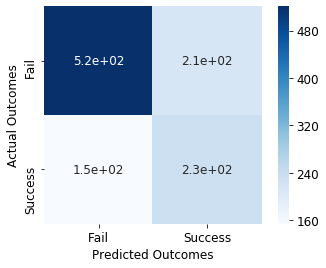

<Figure size 432x288 with 0 Axes>

In [137]:
lr_confusion = confusion_matrix(y_sel_test, [
    1 if item[1] > 0.35 else 0
    for item in lr_tuned.predict_proba(X_sel_test_scaled)
])

sns.heatmap(lr_confusion,
            cmap=plt.cm.Blues,
            annot=True,
            square=True,
            xticklabels=['Fail', 'Success'],
            yticklabels=['Fail', 'Success'])  
b, t = plt.ylim()  # discover the values for bottom and top
b += 0.5  # Add 0.5 to the bottom
t -= 0.5  # Subtract 0.5 from the top
plt.ylim(b, t)  # update the ylim(bottom, top) values
plt.xlabel('Predicted Outcomes')
plt.ylabel('Actual Outcomes')
plt.show()
plt.savefig('img/confusion.png')